In [77]:
import napari
import napari_stress
import tqdm
import vedo

from napari_stress import approximation, measurements

from napari.types import SurfaceData
from napari_stress import measurements
import matplotlib.pyplot as plt
from pygeodesic import geodesic
import pygeodesic
import numpy as np

import napari_process_points_and_surfaces as nppas
from itertools import product, combinations, permutations
import pandas  as pd

## Create sample data

In [38]:
# Get some sample data
pointcloud = napari_stress.get_droplet_point_cloud()[0]

In [39]:
max_degree = 5
fitted_points = napari_stress.fit_spherical_harmonics(pointcloud[0], max_degree=max_degree)

In [40]:
coefficients = fitted_points[1]['metadata']['spherical_harmonics_coefficients']
quadrature_points, lebedev_fit = napari_stress.lebedev_quadrature(coefficients=coefficients, number_of_quadrature_points=250, use_minimal_point_set=False)
manifold = napari_stress.create_manifold(quadrature_points, lebedev_fit=lebedev_fit, max_degree=max_degree)

In [41]:
surface = nppas.surface_from_point_cloud_ball_pivoting(quadrature_points)

## Demonstrate geodesics

In [42]:
viewer = napari.Viewer(ndisplay=3)

In [43]:
viewer.add_points(quadrature_points, size=0.1, face_color='orange')
viewer.add_surface(surface)

<Surface layer 'surface' at 0x1d78c90d790>

In [44]:
geoalg = geodesic.PyGeodesicAlgorithmExact(surface[0], surface[1])

In [45]:
distance, path = geoalg.geodesicDistance(0, 150)
edges = np.diff(path, axis=0)
points = path[:-1]
vectors = np.stack([points, edges]).transpose((1,0,2))

In [46]:
viewer.add_vectors(vectors, edge_width=0.1)

<Vectors layer 'vectors' at 0x1d78c2e2790>

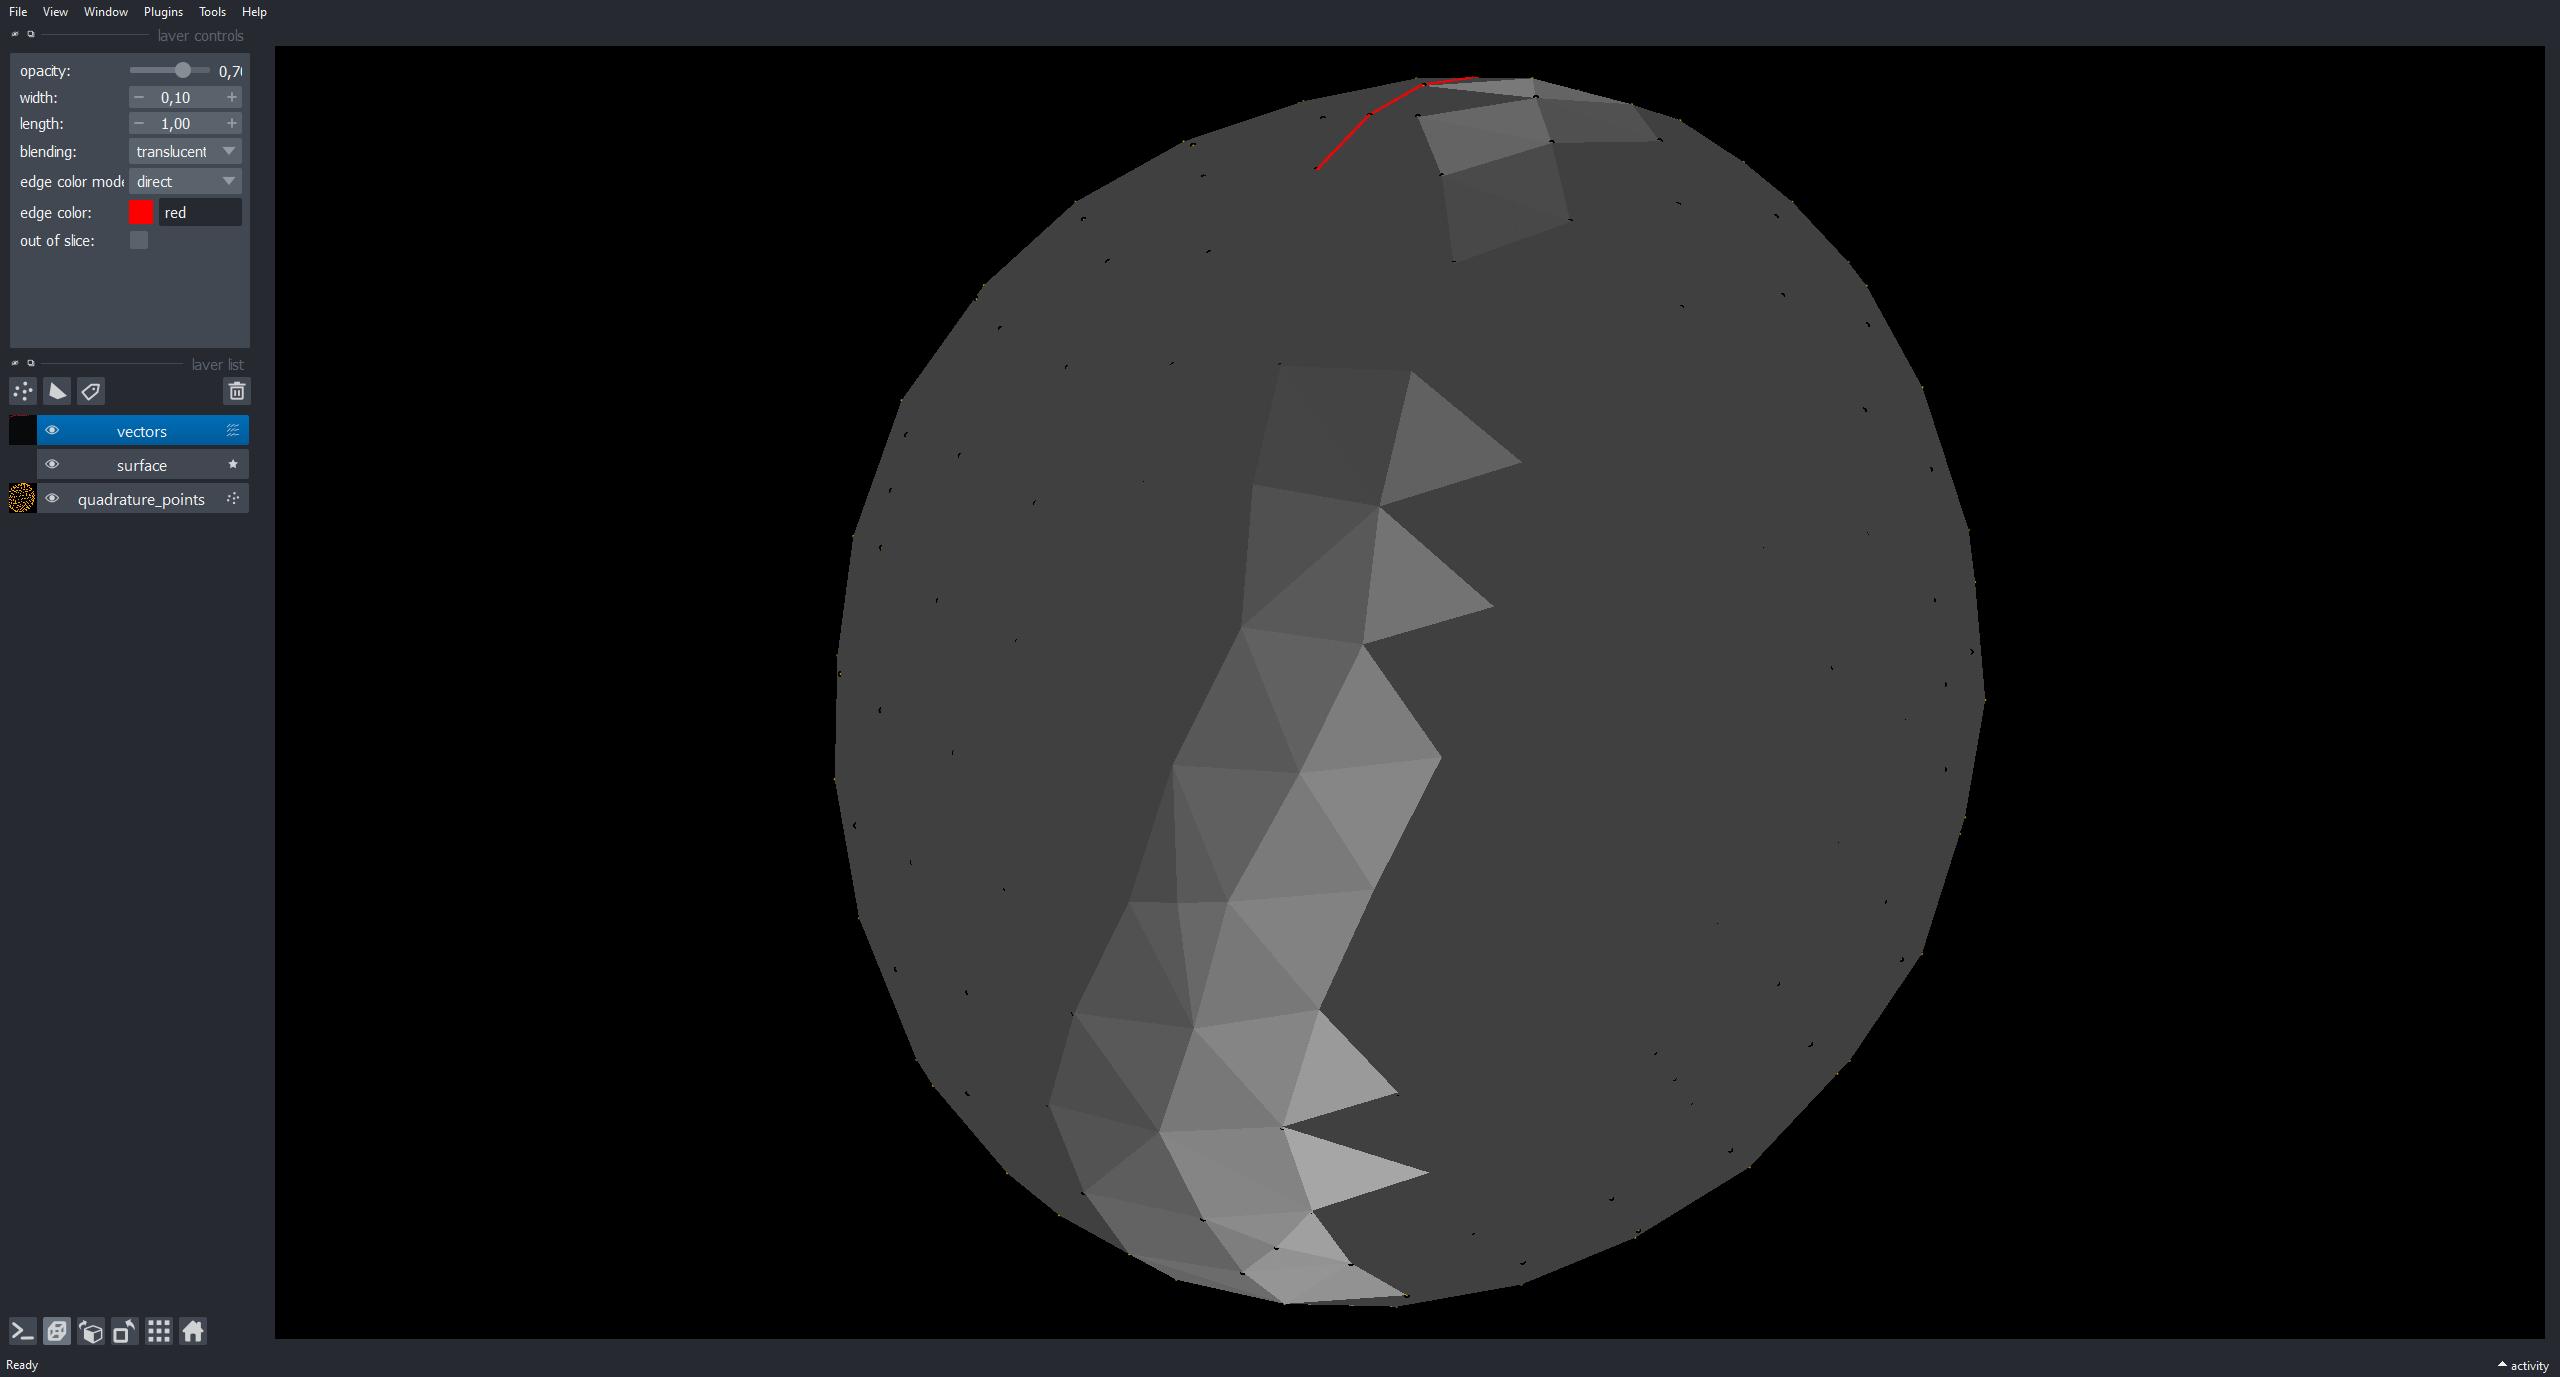

In [47]:
napari.utils.nbscreenshot(viewer)

## Measure stresses

In [48]:
gamma = 26.0

### Ellipsoid fit

First, we fit an ellipsoid to the pointcloud. The ellipsoid represents the tissue-scale stresses.

In [49]:
fitted_ellipsoid = approximation.least_squares_ellipsoid(pointcloud[0])
fitted_ellipse_points = approximation.expand_points_on_ellipse(fitted_ellipsoid, pointcloud[0])

In [50]:
curvature_on_ellipsoid = measurements.curvature_on_ellipsoid(fitted_ellipsoid, fitted_ellipse_points)
H_ellipsoid_major_medial_minor = curvature_on_ellipsoid[1]['metadata']['H_ellipsoid_major_medial_minor']

In [51]:
fitted_ellipse_points_spherical_harmoniocs = napari_stress.fit_spherical_harmonics(fitted_ellipse_points, max_degree=max_degree)
coefficients = fitted_ellipse_points_spherical_harmoniocs[1]['metadata']['spherical_harmonics_coefficients']
quadrature_points, lebedev_fit = napari_stress.lebedev_quadrature(coefficients=coefficients, number_of_quadrature_points=150, use_minimal_point_set=False)
manifold_ellipsoid = napari_stress.create_manifold(quadrature_points, lebedev_fit=lebedev_fit, max_degree=max_degree)

In [52]:
_, _, H0_ellipsoid = measurements.calculate_mean_curvature_on_manifold(manifold_ellipsoid)

quadrature_points_on_ellipsoid = approximation.expand_points_on_ellipse(fitted_ellipsoid, quadrature_points)
mean_curvature_ellipsoid = measurements.curvature_on_ellipsoid(fitted_ellipsoid, quadrature_points_on_ellipsoid)[1]['features']['mean_curvature']

### Spherical harmonics expansion

We now do a spherical harmonics expansion of the raw pointcloud. This also captures the higher orders of curvature on the surface of the droplet.

In [53]:
fitted_points = napari_stress.fit_spherical_harmonics(pointcloud[0], max_degree=max_degree)
fitted_points_layer = viewer.add_points(fitted_points[0], **fitted_points[1], name='spherical harmonics expansion')

In [54]:
coefficients = fitted_points[1]['metadata']['spherical_harmonics_coefficients']
quadrature_points, lebedev_fit = napari_stress.lebedev_quadrature(coefficients=coefficients, number_of_quadrature_points=150, use_minimal_point_set=False)
manifold_droplet = napari_stress.create_manifold(quadrature_points, lebedev_fit=lebedev_fit, max_degree=max_degree)

In [55]:
mean_curvature_spherical_harmonics, _, H0_surface_integral_spherical_harmonics = measurements.calculate_mean_curvature_on_manifold(manifold_droplet)

In [56]:
stress, stress_tissue, stress_droplet = measurements.anisotropic_stress(mean_curvature_spherical_harmonics, H0_surface_integral_spherical_harmonics,
                                                                        mean_curvature_ellipsoid, H0_ellipsoid,
                                                                        gamma=gamma)

## geodesics analysis

In [57]:
viewer2 = napari.Viewer()

In [58]:
surface = nppas.surface_from_point_cloud_ball_pivoting(quadrature_points)
surface = list(nppas.fill_holes(surface))

In [59]:
surface_total = surface + [stress]
surface_tissue = surface + [stress_tissue]
surface_droplet = surface + [stress_droplet]

In [60]:
viewer2.add_surface(surface_total, shading='none', colormap = 'twilight')
viewer2.add_surface(surface_tissue, shading='none', colormap = 'twilight')
viewer2.add_surface(surface_droplet, shading='none', colormap = 'twilight')
viewer2.add_points(quadrature_points, size=0.5)

<Points layer 'quadrature_points' at 0x1d78aea66a0>

In [61]:
mesh = vedo.mesh.Mesh((surface[0], surface[1]))
feature = stress

extrema = np.zeros_like(feature)
for idx in range(mesh.N()):
    feature_neighbors = feature[mesh.connectedVertices(idx)]
    
    if all(feature_neighbors < feature[idx]):
        extrema[idx] = 1
    if all(feature_neighbors > feature[idx]):
        extrema[idx] = -1

In [30]:
result = measurements.geodesic_analysis(surface_total, surface_tissue, surface_droplet)

Calculating geodesic distances: 100%|██████████████████████████████████████████| 10585/10585 [00:06<00:00, 1674.69it/s]


In [ ]:
maxima = surface[0][np.argwhere(result['min_max_distances']['local_maxima_and_minima'] == 1)].squeeze()
minima = surface[0][np.argwhere(result['min_max_distances']['local_maxima_and_minima'] == -1)].squeeze()
viewer2.add_points(maxima, face_color='cyan', size=1.5)
viewer2.add_points(minima, face_color='orange', size=1.5)

In [35]:
result['min_max_distances'][1]

,min_max_pair_distances,min_max_pair_anisotropies
0,17.921399,1.557215
1,31.244292,1.789089
2,26.443318,0.974676
3,16.863573,1.041113
4,12.651446,1.371943
5,35.306854,1.362483
6,13.892705,1.594356
7,16.360795,0.779944
8,28.459377,0.846380
9,22.558149,1.177211


In [66]:
def local_extrema_on_surface(surface: SurfaceData) -> np.ndarray:
    """
    Find local extrema of a feature on a surface.

    Parameters
    ----------
    surface : SurfaceData

    Returns
    -------
    local_extrema : np.ndarray
        Array of length `n_vertices` with 1 = maximum and -1 = minimum

    """
    import vedo
    surface_vedo = vedo.mesh.Mesh([surface[0], surface[1]])

    feature = surface[-1]

    local_extrema = np.zeros_like(feature, dtype=int)

    # iterate over all points, find neighbors and check the feature values
    # at the neighboring points
    for idx in range(surface_vedo.N()):
        ids = surface_vedo.connectedVertices(idx)
        feature_at_neighbor = feature[ids]

        if (feature[idx] > feature_at_neighbor).all():
            local_extrema[idx] = 1

        if (feature[idx] < feature_at_neighbor).all():
            local_extrema[idx] = -1

    return local_extrema

In [75]:
local_extrema = local_extrema_on_surface(surface_total)

# STEP 1
# find distances between all maxima/minima
inter_extremal_distances = np.zeros((len(local_extrema),
                                     len(local_extrema)))

geoalg = geodesic.PyGeodesicAlgorithmExact(surface[0], surface[1])
for idx in np.argwhere(local_extrema != 0):
    distances, _ = geoalg.geodesicDistances(idx)
    inter_extremal_distances[idx] = distances * (local_extrema != 0)

In [111]:
# # STEP 2
# get indices of extrema and the feature anisotropies between all extrema:
# I.e., for 5 maxima and five minima, the result should have length 25,
# for there are 5 neighboring minima for each maximum
distances_max_to_min = []
feature_anisotropy_max_to_min = []
local_min = np.argwhere(local_extrema == -1).squeeze()
for idx, pt in enumerate(np.argwhere(local_extrema == 1).squeeze()):

    delta_distances = inter_extremal_distances[pt][local_min]
    delta_feature = feature[pt] - feature[local_min]
    distances_max_to_min.append(delta_distances)
    feature_anisotropy_max_to_min.append(delta_feature)

distances_max_to_min = np.concatenate(distances_max_to_min)
feature_anisotropy_max_to_min = np.concatenate(
    feature_anisotropy_max_to_min)

is_minimum = local_extrema == -1
is_maximum = local_extrema == 1
distance_to_nearest_extremum = np.zeros_like(local_extrema)

# STEP 3a:
# find pairs of maxima and nearest minima
max_min_pairs = []
max_min_pair_anisotropy = []

for idx in np.argwhere(is_maximum).squeeze():

    # get the inter-extremal distances only between point idx and minima
    distances_to_minima = inter_extremal_distances[idx] * is_minimum

    # find index of nearest minimum
    distances_to_minima[distances_to_minima == 0] = np.nan
    idx_nearest_miniumum = np.nanargmin(distances_to_minima)
    delta_feature = feature[idx] - feature[idx_nearest_miniumum]

    max_min_pairs.append((idx, idx_nearest_miniumum))
    max_min_pair_anisotropy.append(delta_feature)

# STEP 3b:
# find pairs of minimum and nearest maximum
min_max_pairs = []
min_max_pair_anisotropy = []

for idx in np.argwhere(is_minimum).squeeze():
    # get the inter-extremal distances only between point idx and minima
    distances_to_maxima = inter_extremal_distances[idx] * is_maximum

    # find index of nearest maximum
    distances_to_maxima[distances_to_maxima == 0] = np.nan
    idx_nearest_maximum = np.nanargmin(distances_to_maxima)
    delta_feature = feature[idx] - feature[idx_nearest_maximum]

    min_max_pairs.append((idx, idx_nearest_maximum))
    min_max_pair_anisotropy.append(delta_feature)

# Step 4: Format results as dataframe
df = pd.DataFrame(np.argwhere(local_extrema != 0).squeeze(),
                  columns=['local_extrema'])
df['is_maximum'] = local_extrema[df['local_extrema']] == 1
df['is_minimum'] = local_extrema[df['local_extrema']] == -1

In [102]:
df['nearest_extremum'] = ''
df['distance_to_nearest_extremum'] = ''
df['feature_anisotropy_to_nearest_extremum'] = ''

In [109]:
distances_to_minima = distances_to_minima[~np.isnan(distances_to_minima)]
distances_to_maxima = distances_to_maxima[~np.isnan(distances_to_maxima)]
for idx, pair in enumerate(max_min_pairs):
    df.loc[df['local_extrema'] == pair[0],  'nearest_extremum'] = pair[1]
    df.loc[df['local_extrema'] == pair[0],  'distance_to_nearest_extremum'] = distances_to_minima[idx]
    df.loc[df['local_extrema'] == pair[0],  'feature_anisotropy_to_nearest_extremum'] = max_min_pair_anisotropy[idx]
    
for idx, pair in enumerate(min_max_pairs):
    df.loc[df['local_extrema'] == pair[0],  'nearest_extremum'] = pair[1]
    df.loc[df['local_extrema'] == pair[0],  'distance_to_nearest_extremum'] = distances_to_maxima[idx]
    df.loc[df['local_extrema'] == pair[0],  'feature_anisotropy_to_nearest_extremum'] = min_max_pair_anisotropy[idx]

In [110]:
df

,local_extrema,is_maximum,is_minimum,nearest_extremum,distance_to_nearest_extremum,feature_anisotropy_to_nearest_extremum
0,9,False,True,137,12.651446,-2.138958
1,20,False,True,144,22.558149,-3.275075
2,54,True,False,142,18.398932,1.371943
3,59,False,True,74,30.600529,-0.779944
4,63,False,True,137,38.586234,-1.622855
5,74,True,False,20,12.457544,1.594356
6,101,True,False,20,38.038728,1.540465
7,137,True,False,63,35.60953,1.622855
8,142,False,True,54,13.23774,-1.371943
9,144,True,False,20,13.23774,3.275075


array([18.39893159, 12.45754419, 38.03872848, 35.60952968, 13.23773962])